## Пример решения ДЗ

### Необходимые импорты библиотек

In [1]:
import pandas as pd
import numpy as np

In [2]:
from datetime import datetime

In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_percentage_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

### Загрузка данных

Читаем файлы из базы данных в датафреймы пандас

In [4]:
app_sess = pd.read_csv('app_sess.csv')

customers = pd.read_csv('customers.csv')

delivery_info = pd.read_csv('info.csv')

orders_product = pd.read_csv('orders_product.csv')

orders = pd.read_csv('orders.csv')

products = pd.read_csv('products.csv')

### Создание целевой переменной

Джойн таблиц с заказами и доставками для получения времени доставки в днях

In [5]:
order_delivery = pd.merge(orders, delivery_info, on='order_id')

Выберем те даты, при которых доставка была полностью завершена. Если строить модель с использованием времени незавешенных заказов, то можно модели передать недостоверную информацию и понизить ее качество.

In [6]:
order_delivery = order_delivery[order_delivery['is_completed_flg']].reset_index(drop=True)

Приведение к типу "дата"

In [7]:
order_delivery['delivery_dt'] = pd.to_datetime(order_delivery['delivery_dt'])
order_delivery['order_dt'] = pd.to_datetime(order_delivery['order_dt'])

C:\Users\abuza\AppData\Local\Temp\ipykernel_14040\915729794.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  order_delivery['order_dt'] = pd.to_datetime(order_delivery['order_dt'])


Получение времени доставки

In [8]:
order_delivery['delivery_time'] = (order_delivery['delivery_dt'] - order_delivery['order_dt'])\
    .apply(lambda x: x.days)

In [9]:
order_delivery.head()

,order_id,customer_id,order_dt,payment_method,delivery_id,delivery_dt,is_completed_flg,delivery_time
0,99983,4951223,2021-07-12,offline,81,2017-01-20,True,-1634
1,99983,4951223,2021-07-12,offline,1006,2024-12-20,True,1257
2,99983,4951223,2021-07-12,offline,1241,2004-01-20,True,-6383
3,99969,1806908,2022-07-29,offline,1071,2003-09-20,True,-6887
4,99969,1806908,2022-07-29,offline,1268,2031-08-20,True,3309


Нужно обратить внимание, что на один order_id приходится несколько дат доставки - поскольку в задание это никак не оговорено, можно взять как максимум, так и среднее, так и минимум и времени доставок

In [10]:
order_target = order_delivery[['order_id', 'delivery_time']]\
    .groupby(by='order_id').max()\
    .reset_index()

In [11]:
order_target

,order_id,delivery_time
0,87,2245
1,97,-5056
2,109,-6872
3,181,3650
4,184,-2871
...,...,...
1170,99662,-4681
1171,99708,-2269
1172,99710,-5790
1173,99969,3309


<Axes: >

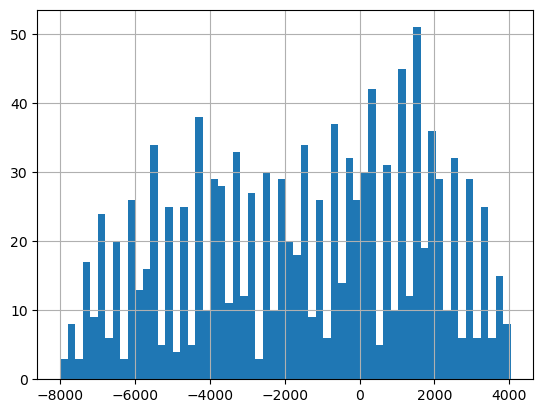

In [12]:
order_target['delivery_time'].hist(bins=60)

Полученная целевая переменная принимает целочисленные значения, начиная с единицы. По своей природе время доставки теоритически может быть любым - значит нельзя заранее выбрать конечное число классов, а значит рассматривается задача регрессии. В качестве целевой метрики лучше взять MAPE, поскольку по смыслу задачи интересно знать процентное отклонение от ожидаемого времени доставки. Использование метрик MAE и MSE/RMSE также возможно, для понимания средних абсолютных ошибок. Также можно использовать метрику R^2 для понимая адекватности предсказаний в смысле их вариативности

### Генерация признаков

В качестве признаков используем информацию о содержимом в заказах.
Общая информация:
- Суммарное число товаров
- Суммарная стоимость товаров

Информация по группам:
- Суммарное количество товаров в разрезе группы товаров
- Суммарная стоимость товаров в разрезе группы товаров

Сопоставление заказов и продуктов

In [13]:
orders_products = pd.merge(orders_product, products, on='product_id')

In [14]:
orders_products['total_price'] = orders_products['Price']*orders_products['amount']

In [15]:
orders_products.head()

,order_id,product_id,amount,product_group_name,product_name,Price,total_price
0,52414,4,33,Одежда,Рубашка,15000,495000
1,7695,4,21,Одежда,Рубашка,15000,315000
2,22012,4,8,Одежда,Рубашка,15000,120000
3,8509,4,50,Одежда,Рубашка,15000,750000
4,82238,4,27,Одежда,Рубашка,15000,405000


Общие статистики

In [16]:
orders_general = \
    orders_products[['order_id', 'amount', 'total_price']].groupby(by='order_id').sum().reset_index()

In [17]:
orders_general.head()

,order_id,amount,total_price
0,87,41,615000
1,97,138,39640
2,105,35,700
3,109,69,21960
4,112,10,1000


In [18]:
orders_general.shape

(2635, 3)

Статистики по группам

In [19]:
orders_groups = orders_products[['order_id', 'product_group_name', 'amount', 'total_price']]\
    .groupby(by=['order_id', 'product_group_name']).sum().reset_index()

In [20]:
orders_groups = pd.pivot(orders_groups, index=['order_id'], columns=['product_group_name'])

In [21]:
orders_groups.columns = ['_'.join(x) for x in orders_groups.columns]

In [22]:
orders_groups.reset_index(inplace=True)

In [23]:
orders_groups.head()

,order_id,amount_Напитки,amount_Одежда,amount_Продукты,amount_Часы,total_price_Напитки,total_price_Одежда,total_price_Продукты,total_price_Часы
0,87,NaN,41.0,NaN,NaN,NaN,615000.0,NaN,NaN
1,97,17.0,36.0,47.0,38.0,1700.0,18000.0,940.0,19000.0
2,105,35.0,NaN,NaN,NaN,700.0,NaN,NaN,NaN
3,109,48.0,NaN,NaN,21.0,960.0,NaN,NaN,21000.0
4,112,10.0,NaN,NaN,NaN,1000.0,NaN,NaN,NaN


In [24]:
orders_groups.shape

(2635, 9)

Ограничимся этими признаками, поскольку по природе задачи объем и дороговизна товаров кажутся одними из самых важных признаков. Добавить можно произвольное количество других - закодировать адрес, добавить возраст покупателя, количество операционок пользователя, время использования приложения на момент заказа и т.д. С точки зрения задания, чем больше креатива проявляет слушатель - тем лучше.

Формирование финальной таблицы с данными - левые джойны целевой переменной с признаками

In [25]:
order_info_and_target = pd.merge(order_target, orders_general, on='order_id', how='left')

In [26]:
order_info_and_target = pd.merge(order_info_and_target, orders_groups, on='order_id', how='left')

In [27]:
order_info_and_target.head()

,order_id,delivery_time,amount,total_price,amount_Напитки,amount_Одежда,amount_Продукты,amount_Часы,total_price_Напитки,total_price_Одежда,total_price_Продукты,total_price_Часы
0,87,2245,41.0,615000.0,NaN,41.0,NaN,NaN,NaN,615000.0,NaN,NaN
1,97,-5056,138.0,39640.0,17.0,36.0,47.0,38.0,1700.0,18000.0,940.0,19000.0
2,109,-6872,69.0,21960.0,48.0,NaN,NaN,21.0,960.0,NaN,NaN,21000.0
3,181,3650,80.0,13950.0,55.0,NaN,25.0,NaN,12700.0,NaN,1250.0,NaN
4,184,-2871,77.0,540900.0,NaN,77.0,NaN,NaN,NaN,540900.0,NaN,NaN


### Обработка данных и моделирование

Выделим признаковое описание и целевой столбец

In [28]:
X = order_info_and_target.drop(columns=['order_id', 'delivery_time'])
y = order_info_and_target['delivery_time']

Поскольку для оценки качества моделей предполагается использование кросс-валидации, воспользуемся классом Pipeline из библиотеки sklearn, чтобы предотвратить утечку информации.

В полученном признаковом описании отсутствуют категориальные переменные - значит соответствующие кодировки не нужны. При этом есть как признаки разных масштабов, так и пропуски. Поэтому добавим нормализацию и заполнения пропусков

При этом вспомним, что нормализация для древесных моделей не требуется - учтем это при использовании соответствующих пайплайнов.

In [29]:
sc = StandardScaler()
si = SimpleImputer()

In [30]:
lr = LinearRegression()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()

In [31]:
lr_pipeline = Pipeline([('si', si), ('sc', sc), ('lr', lr)])
dt_pipeline = Pipeline([('si', si), ('dt', dt)])
rf_pipeline = Pipeline([('si', si), ('rf', rf)])

In [32]:
kfold = KFold(n_splits=5)

In [33]:
lr_pred = cross_val_predict(estimator=lr_pipeline, X=X, y=y, cv=kfold)
dt_pred = cross_val_predict(estimator=dt_pipeline, X=X, y=y, cv=kfold)
rf_pred = cross_val_predict(estimator=rf_pipeline, X=X, y=y, cv=kfold)

Результат медианой и средним для сравнения

In [34]:
mean_absolute_percentage_error(y, [np.median(y)]*y.shape[0])

5.177771990792434

In [35]:
mean_absolute_percentage_error(y, [np.mean(y)]*y.shape[0])

6.527043585503089

Результат линейной модели

In [36]:
mean_absolute_percentage_error(y, lr_pred)

7.138036442384436

In [37]:
r2_score(y, lr_pred)

-0.007571754305745415

Результат дерева решений

In [38]:
mean_absolute_percentage_error(y, dt_pred)

8.716108302076021

In [39]:
r2_score(y, dt_pred)

-0.8394798294913453

Результат случайного леса

In [40]:
mean_absolute_percentage_error(y, rf_pred)

6.940807807702176

In [41]:
r2_score(y, rf_pred)

-0.14085905345638405

Как результат получены значения метрик, видно, что модели работают хуже предсказания средним - выбранные признаки могли оказаться недостаточно информативными, либо целевая переменная плохо прогнозируема в целом